<a href="https://colab.research.google.com/github/ArtemNechaev/stepik_nnets/blob/main/task2_word_embeddings_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 13.58 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (51/51), done.
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 1.7 MB 11.5 MB/s 
     |████████████████████████████████| 24.2 MB 3.0 MB/s 
     |████████████████████████████████| 6.0 MB 31.3 MB/s 
     |████████████████████████████████| 304 kB 48.2 MB/s 
     |████████████████████████████████| 628 kB 40.3 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 451 kB 41.8 MB/s 
     |████████████████████████████████| 181 kB 41.8 MB/s 
     |████████████████████████████████| 10.1 MB 19.5 MB/s 
     |████████████████████████████████| 8.2

In [ ]:
%load_ext autoreload
%autoreload 2
!python -m spacy download en_core_web_sm
import re
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import Dataset

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, texts_to_token_ids, \
    PaddedSequenceDataset, Embeddings
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed
from dlnlputils.visualization import plot_vectors

init_random_seed()

     |████████████████████████████████| 13.9 MB 4.7 MB/s 
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
MODEL_NAME = 'FastText'
IS_LEMM = False

## Загрузка данных и подготовка корпуса

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
full_dataset = list(pd.read_csv('./stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv')['input'].dropna())
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.7)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 125344
Тестовая выборка 53719

1/4 cup sour cream
10 ounces swordfish, red snapper or other firm-fleshed fish
1 tablespoon minced basil leaves
Handful fresh parsley, finely minced
4 ounces lard or butter, plus more for brushing tops
4 to 5 green cardamom pods
1 stick ( 1/4 pound) unsalted butter, softened
1/4 teaspoon red pepper flakes, preferably Turkish or Aleppo (see note), more to taste
1 tablespoon fresh lemon juice
1/4 cup scallions, thinly sliced


In [ ]:
# токенизируем
import spacy

if IS_LEMM:
  spacy.prefer_gpu()
  nlp = spacy.load("en_core_web_sm")
  train_tokenized = [[token.lemma_.lower() + '_' + str(token.pos_) for token in text if (token.pos!= 93) & (token.pos != 97) ] for text in nlp.pipe(train_source)]
  test_tokenized = [[token.lemma_.lower() + '_' + str(token.pos_) for token in text if (token.pos!= 93) & (token.pos != 97) ] for text in nlp.pipe(test_source)]
else:
  train_tokenized = tokenize_corpus(train_source)
  test_tokenized = tokenize_corpus(test_source)

print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

sour cream
ounces swordfish snapper other firm fleshed fish
tablespoon minced basil leaves
handful fresh parsley finely minced
ounces lard butter plus more brushing tops
green cardamom pods
stick pound unsalted butter softened
teaspoon pepper flakes preferably turkish aleppo note more taste
tablespoon fresh lemon juice
scallions thinly sliced


In [ ]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
if MODEL_NAME == 'FastText':
  token2subwords = []
  first_ngram_index = len(vocabulary)
  tokenizer = re.compile(r'(?=(\w{3}))')
  counter = first_ngram_index
  for word, index_word in vocabulary.copy().items(): 
    subwords = tokenizer.findall(word)
    subwords_ids = [index_word]
    for s in subwords:
      if s not in vocabulary:
        vocabulary[s] = counter
        subwords_ids.append(counter)
        counter += 1
    token2subwords.append(subwords_ids) 


print("Размер словаря", len(vocabulary))
print("Количесво реальных слов", first_ngram_index)
print(list(vocabulary.items())[:10])
print(list(vocabulary.items())[-10:])

Размер словаря 4685
Количесво реальных слов 2267
[('<PAD>', 0), ('tablespoons', 1), ('teaspoon', 2), ('chopped', 3), ('salt', 4), ('pepper', 5), ('cups', 6), ('ground', 7), ('fresh', 8), ('tablespoon', 9)]
[('ztr', 4675), ('idu', 4676), ('dua', 4677), ('weh', 4678), ('eha', 4679), ('sot', 4680), ('owa', 4681), ('wav', 4682), ('bhu', 4683), ('iot', 4684)]


In [ ]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

222 52
22 878 574 127 246 707 181
9 19 88 33
517 8 43 15 19
22 586 20 45 47 649 648
59 329 535
200 12 50 20 266
2 5 140 78 1208 735 153 47 10
9 8 31 25
98 65 27


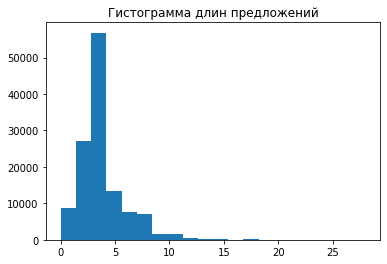

In [ ]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

## Генерация данных



In [ ]:
def generate_w2v_sgns_samples(text, window_size, vocab_size, token2subwords = []):
    """
    text - list of integer numbers - ids of tokens in text
    window_size - odd integer - width of window
    vocab_size - positive integer - number of tokens in vocabulary
    token2subwords - list of lists of int - i-th sublist contains list of identifiers of n-grams for token #i (list of subword units)
    returns list of training samples (CenterWord, CtxWord, Label)
    """
    result = []
    text_size = len(text)
    text = np.array(text)
    assert((window_size-1) % 2 == 0)
    for i in range(1,int((window_size-1)/2) + 1):
        if (text_size-i) < 1:
                break 
        ones = np.ones(text_size-i)
        right_words = np.column_stack((text[:-i],text[i:], ones))
        left_words = np.column_stack((text[i:],text[:-i], ones))
    
        result.append(right_words)
        result.append(left_words)

    if len(result) > 0:
      result = np.concatenate(result).astype('int')

      # примеры для fasttext
      if len(token2subwords) > 0:
        result = np.concatenate(
            [[ (r[0], subword, 1) for subword in token2subwords[r[1]]]  for r in result]
            )
      
    return result


class DeSemDataset(Dataset):
    def __init__(self, data, vocab_size,  window_size=5,  n_samples = 20, concat_sent=True, token2subwords=[]):
      super().__init__()
      if concat_sent:
        data = np.concatenate(data)
        self.data = generate_w2v_sgns_samples(data, window_size, vocab_size, token2subwords=token2subwords )
      else:
        temp_data=[]
        for d in data:
          samples = generate_w2v_sgns_samples(d, window_size, vocab_size, token2subwords=token2subwords )
          if len(samples)>0:
            temp_data.append(samples)
        self.data = np.concatenate(temp_data)
        
      #Разбиваем данные на пакеты для более быстрого обчения иначе тормозит при формировании batch -ей
      # Увеличиваем число примеров до величины кратной n_samples 
      n_pad_samples = int(np.ceil(self.data.shape[0]/n_samples)*n_samples - self.data.shape[0]) 
      self.data = np.concatenate((self.data, np.zeros((n_pad_samples,3)))).reshape(-1,n_samples,3)

    def __len__(self):
      return len(self.data )

    def __getitem__(self, id):
      center_word = torch.tensor(self.data[id,:,0], dtype=torch.long)
      contex_word = torch.tensor(self.data[id,:,1], dtype=torch.long)
      is_real_contex_word = self.data[id,:,2]
      return (center_word, contex_word), torch.tensor(is_real_contex_word, dtype=torch.long)


## Алгоритм обучения - Skip Gram Negative Sampling

**Skip Gram** - предсказываем соседние слова по центральному слову

**Negative Sampling** - аппроксимация softmax

$$ W, D \in \mathbb{R}^{Vocab \times EmbSize} $$

$$ \sum_{CenterW_i} P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) \rightarrow \max_{W,D} $$

$$ P(CtxW_{-2}, CtxW_{-1}, CtxW_{+1}, CtxW_{+2} | CenterW_i; W, D) = \prod_j P(CtxW_j | CenterW_i; W, D) $$
    
$$ P(CtxW_j | CenterW_i; W, D) = \frac{e^{w_i \cdot d_j}} { \sum_{j=1}^{|V|} e^{w_i \cdot d_j}} = softmax \simeq \frac{e^{w_i \cdot d_j^+}} { \sum_{j=1}^{k} e^{w_i \cdot d_j^-}}, \quad k \ll |V| $$

**Negative Sampling** работает следующим образом - мы **максимизируем сумму вероятностей двух событий**: 

* "этот пример центрального слова вместе с контекстными словами взят **из тренировочной выборки**": $$ P(y=1 | CenterW_i; CtxW_j) = sigmoid(w_i \cdot d_j) = \frac{1}{1+e^{-w_i \cdot d_j}} $$

$$ \\ $$

* "этот пример центрального слова вместе со случайми контекстными словами **выдуман** ": $$ P(y=0 | CenterW_i; CtxW_{noise}) = 1 - P(y=1 | CenterW_i;  CtxW_{noise}) = \frac{1}{1+e^{w_i \cdot d_{noise}}} $$

$$ \\ $$

$$ NEG(CtxW_j, CenterW_i) = log(\frac{1}{1+e^{-w_i \cdot d_j}}) + \sum_{l=1}^{k}log(\frac{1}{1+e^{w_i \cdot d_{noise_l}}})  \rightarrow \max_{W,D} $$

In [ ]:

class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0
    
    def forward(self, sample):
        """sample - Batch x N_Samples - идентификаторы токенов"""
        
        center_words = sample[0]
        contex_words = sample[1]

        batch_size = center_words.shape[0]
        center_embeddings = self.center_emb(center_words)  # Batch x N_Samples x EmbSize 
        context_embs = self.context_emb(contex_words) #  Batch x N_Samples x EmbSize 
        sims =  (center_embeddings * context_embs).sum(2) 
        pos_loss = F.binary_cross_entropy_with_logits(sims, sims.new_ones(sims.shape))     


        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n,),
                                       device=center_words.device)  # (Batch x NegSamplesN)
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN 
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x N_Samples x NegSamplesN
        
        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))
        return pos_loss + negative_loss
    def loss(self, pred, target):
      return  pred


## Обучение

In [ ]:
train_dataset = DeSemDataset(train_token_ids, len(vocabulary),  window_size=5,  
                              concat_sent=False, token2subwords=token2subwords)
test_dataset = DeSemDataset(test_token_ids, len(vocabulary),  window_size=5,  
                             concat_sent=False, token2subwords=token2subwords)

trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100)
len(train_dataset)/20

10365.0

In [ ]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            trainer.loss,
                                            lr=1e-3,
                                            epoch_n=10,
                                            batch_size=100,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=9000,
                                            max_batches_per_epoch_val=9000,
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 2073 итераций, 32.46 сек
Среднее значение функции потерь на обучении 0.6604417945472618
Среднее значение функции потерь на валидации 0.5129859881607566
Новая лучшая модель!

Эпоха 1
Эпоха: 2073 итераций, 32.49 сек
Среднее значение функции потерь на обучении 0.47126809515874857
Среднее значение функции потерь на валидации 0.4455711565015018
Новая лучшая модель!

Эпоха 2
Эпоха: 2073 итераций, 34.45 сек
Среднее значение функции потерь на обучении 0.4201730283716711
Среднее значение функции потерь на валидации 0.41694527002904225
Новая лучшая модель!

Эпоха 3
Эпоха: 2073 итераций, 34.22 сек
Среднее значение функции потерь на обучении 0.39431295412724227
Среднее значение функции потерь на валидации 0.4017605666234603
Новая лучшая модель!

Эпоха 4
Эпоха: 2073 итераций, 32.77 сек
Среднее значение функции потерь на обучении 0.3789440309489573
Среднее значение функции потерь на валидации 0.3930830859293149
Новая лучшая модель!

Эпоха 5
Эпоха: 2073 итераций, 32.39 сек
Среднее знач

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), './stepik-dl-nlp/models/sgns.pth')

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('./stepik-dl-nlp/models/sgns.pth'))

## Исследуем характеристики полученных векторов

In [ ]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [ ]:
embeddings.most_similar('chicken')

[('chicken', 0.99996716),
 ('turkey', 0.77781665),
 ('tenders', 0.77607566),
 ('pheasant', 0.75036305),
 ('thighs', 0.74387497),
 ('muscovy', 0.7402083),
 ('breasts', 0.7394868),
 ('drumsticks', 0.7340399),
 ('brisket', 0.72569025),
 ('duck', 0.72176063)]

In [ ]:
embeddings.analogy('cacao', 'cake', 'cheese')

[('cake', 1.0023553),
 ('cheese', 0.9706435),
 ('fontina', 0.8100624),
 ('danish', 0.8056646),
 ('gruyère', 0.800257),
 ('sponge', 0.7993986),
 ('gruyere', 0.799019),
 ('asiago', 0.7952298),
 ('monterey', 0.7687603),
 ('salata', 0.76522565)]

In [ ]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee','cheese',  'sausage', 'wine',  'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
#test_words = [t +'_NOUN' for t in test_words]
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(18, 100)


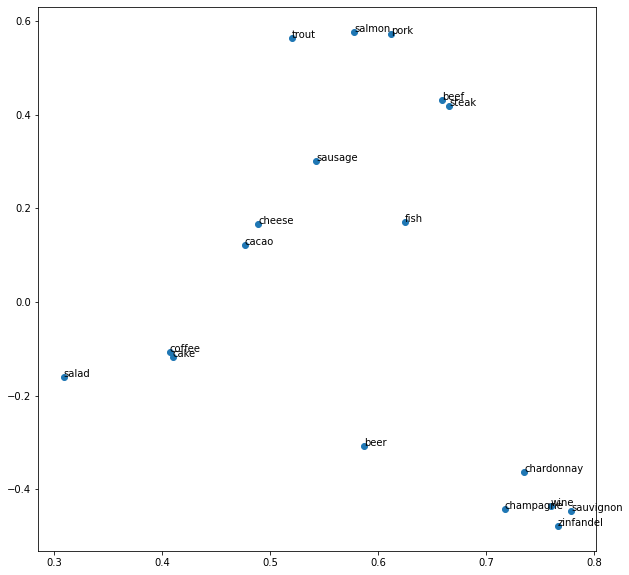

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

## Обучение Word2Vec с помощью Gensim

In [ ]:
import gensim

In [ ]:
word2vec = gensim.models.Word2Vec(sentences=train_tokenized, size=100,
                                  window=5, min_count=5, workers=4,
                                  sg=1, iter=10)

In [ ]:
word2vec.wv.most_similar('chicken')

[('duck', 0.7161048054695129),
 ('thighs', 0.6959372162818909),
 ('turkey', 0.6904381513595581),
 ('defatted', 0.6903325319290161),
 ('simmering', 0.6902222633361816),
 ('drumsticks', 0.6713442802429199),
 ('pheasant', 0.6603108644485474),
 ('breasts', 0.6522116661071777),
 ('breast', 0.6467052698135376),
 ('magret', 0.6395127773284912)]

In [ ]:
gensim_words = [w for w in test_words if w in word2vec.wv.vocab]
gensim_vectors = np.stack([word2vec.wv[w] for w in gensim_words])

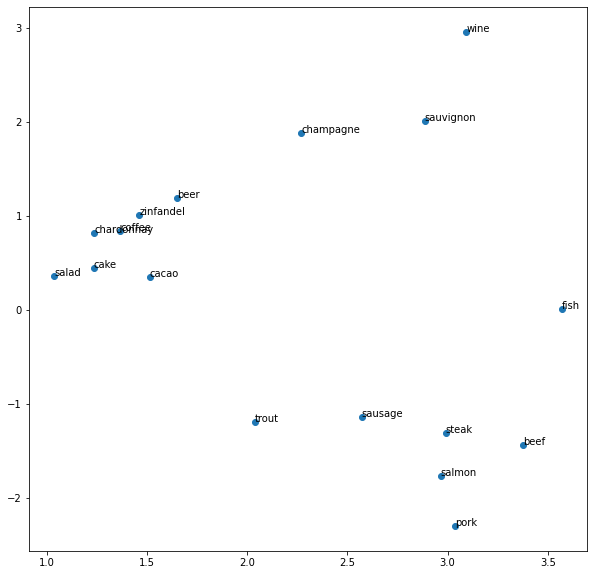

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(gensim_vectors, test_words, how='svd', ax=ax)

## Загрузка предобученного Word2Vec

Источники готовых векторов:

https://rusvectores.org/ru/ - для русского языка

https://wikipedia2vec.github.io/wikipedia2vec/pretrained/ - много разных языков

In [ ]:
import gensim.downloader as api

In [ ]:
available_models = api.info()['models'].keys()
print('\n'.join(available_models))

In [ ]:
pretrained = api.load('word2vec-google-news-300')  # > 1.5 GB!

In [ ]:
pretrained.most_similar('cheese')

In [ ]:
pretrained.most_similar(positive=['man', 'queen'], negative=['king'])

In [ ]:
pretrained_words = [w for w in test_words if w in pretrained.vocab]
pretrained_vectors = np.stack([pretrained[w] for w in pretrained_words])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(pretrained_vectors, test_words, how='svd', ax=ax)

## Заключение

* Реализовали Skip Gram Negative Sampling на PyTorch
* Обучили на корпусе рецептов
    * Сходство слов модель выучила неплохо
    * Для аналогий мало данных
* Обучили SGNS с помощью библиотеки Gensim
* Загрузили веса Word2Vec, полученные с помощью большого корпуса (GoogleNews)
    * Списки похожих слов отличаются!
    * Аналогии работают